<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">Otimização do Modelo SARIMA</font></b></strong>

No modelo 18 criamos um Modelo SARIMA aplicando Grid Search Stepwise para buscar os melhores valores dos hiperparâmetros.

Agora, vamos tentar melhorar a performance do modelo criado mudando a estratégia do Grid Search.  

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#matplotlib.style.use('ggplot')
#%matplotlib inline

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

statsmodels     0.11.1
statsmodels.api 0.11.1
scipy           1.5.4
matplotlib      3.2.2
pandas          1.0.5
sklearn         0.23.1
numpy           1.16.6
Data Science Academy


## Definição do Problema de Negócio

Previsão do número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH. Os dados tem registros dos anos de 2010 a 2020.

Será fornecido 1 dataset com 2 colunas, data e número de Óbitos.

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares – AIH em Minas Gerais.

Os dados foram baixados do site do Datasus, módulo SIHSUS, tipo de arquivo RD- AIH Reduzida, anos de 2010 a 2020, UF MG, todos os meses:

http://www2.datasus.gov.br/DATASUS/index.php?area=0901&item=1&acao=25

Foi realizado o download de 129 arquivos, com 5.231.829 registros utilizados para preparar um arquivo csv com o agrupamento das internações das pessoas acima de 50 anos que vieram a óbito, perfazendo um total de 3.896 registros diários, 556 registros por semana (excluindo-se a primeira e a última), com data, número e valor total das internações, dados desde 2010.

In [3]:
# Carrega os dados
dataframediario = pd.read_csv("./data/AIH.csv")
dataframediario['Data'] = pd.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows

In [4]:
# Dados
dataframe.head()

,QT_INTER
Data,
2010-01-10,697
2010-01-17,678
2010-01-24,720
2010-01-31,684
2010-02-07,700


In [5]:
# Refinamos os dados para o gráfico da série original
# A variável File_System é nossa variável target 
target = dataframe['QT_INTER']

In [6]:
# Random seed 
np.random.seed(7)

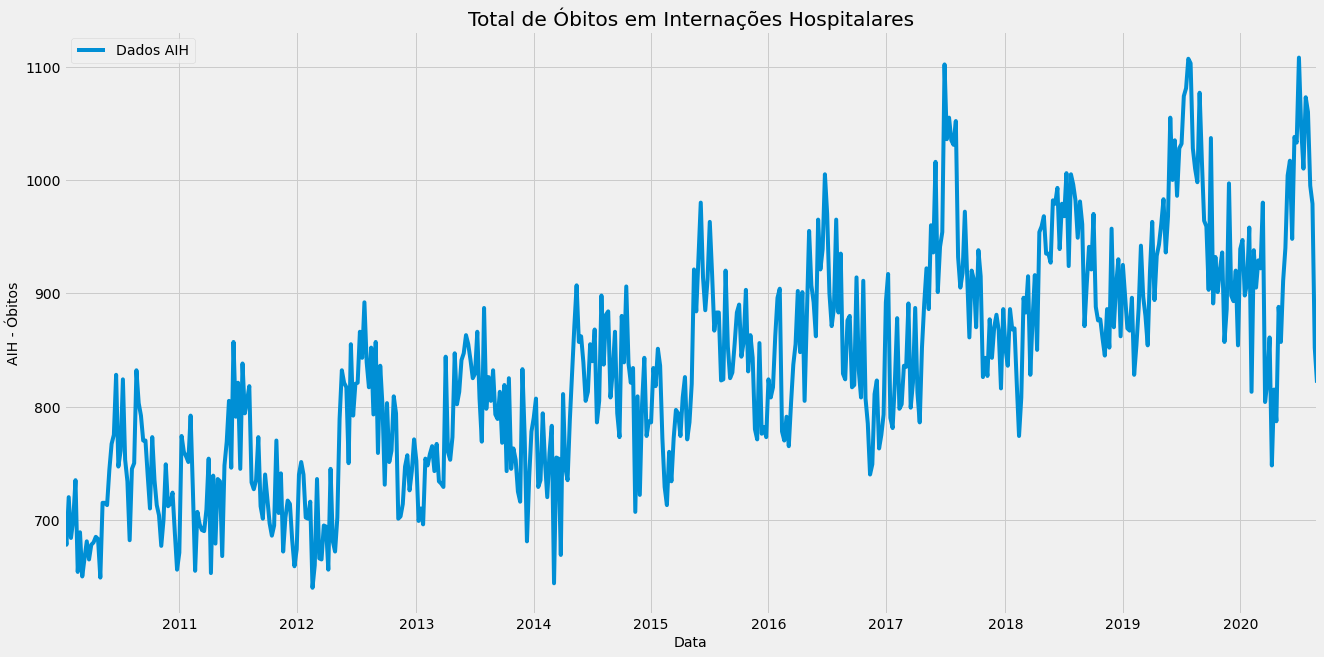

In [7]:
# Plot
target.plot(title = 'Total de Óbitos em Internações Hospitalares', fontsize = 14, label = 'Dados AIH') 
plt.xlabel("Data") 
plt.ylabel("AIH - Óbitos") 
plt.legend(loc = 'best') 
plt.show()

In [8]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

417 139


In [9]:
# Aplicando transformação de log
#treino_log = np.log(treino) 

In [10]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
#teste_log = np.log(teste)

In [11]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Otimização do Modelo SARIMA

### Grid Search Método 2 

Neste método de Grid Search, nós testamos diversas combinações dos hiperparâmetros do modelo SARIMA. Tome cuidado para não exagerar nas combinações. Valores de 0 e 1 resolvem a grande maioria dos problemas.

In [12]:
# Vamos definir p, d e q para que tenham valores entre 0 e 2 e testaremos as combinações.
p = d = q = range(0, 2)

Agora geramos diferentes combinações de p, d e q.

In [13]:
# Lista de combinações de p, d, q
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [14]:
# Lista de combinações dos hiperparâmetros sazonais P, D e Q
# Estamos usando List Comprehension
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [15]:
print('\nExemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:\n')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Exemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [16]:
# Grid Search
#warnings.filterwarnings("ignore")

# Menor valor possível para a estatística AIC (nosso objetivo na otimização do modelo)
lowest_aic = sys.maxsize
lowest = ''

# Loop
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            # Cria o modelo com a combinação dos hiperparâmetros
            mod = sm.tsa.statespace.SARIMAX(treino,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            
            # Treina o modelo
            results = mod.fit()
            
            # Print
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # Coleta o menor valor de AIC
            if lowest_aic >  results.aic:
                lowest = 'SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print ("\nModelo com Menor Valor de AIC: " + lowest)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6747.812442904518
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:4726.6530437125
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4441.5472256249695
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4739.358646820116
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:4547.36004189772
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4567.15732621164
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:4440.550867256377
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6197.8165247338075
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5655.9144062801415
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:4606.740799548137
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:4298.110228476815
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:4629.768555436219


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:4624.458008969785
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:4439.279552367871
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:4299.593843952072
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:4452.598374218069
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4331.962601741061
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:4618.206274557229
SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:4239.964600194053
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:4341.761373046871
SARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:4333.897756065493
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:4407.270480780598
SARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:4241.690147956604
SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:4338.7073610490625
SARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:4223.097286308312
SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:4508.44403414146
SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:4131.6341154938345
SARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:4242.280826826341
SARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:4225.046420485772
SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:4314.1768

In [17]:
# Treina o modelo com a melhor combinação de hiperparâmetros
modelo_sarima_v2 = sm.tsa.statespace.SARIMAX(treino,
                                             order = (0, 1, 1),
                                             seasonal_order = (0, 1, 1, 12),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

In [18]:
# Treinamento (Fit) do modelo
modelo_sarima_v2_fit = modelo_sarima_v2.fit()

In [19]:
# Sumário do modelo
print(modelo_sarima_v2_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           QT_INTER   No. Observations:                  417
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2062.817
Date:                            Wed, 25 Nov 2020   AIC                           4131.634
Time:                                    18:14:32   BIC                           4143.533
Sample:                                01-10-2010   HQIC                          4136.351
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5716      0.042    -13.529      0.000      -0.654      -0.489
ma.S.L12      -1.0000      0.073   

Nas próximas aulas vamos interpretar o sumário do modelo e comparar as versões dos modelos SARIMA que iremos criar.

Mas perceba o valor de AIC. Conseguimos reduzí-lo de forma considerável e a única mudança foi a otimizaçã dos hiperparâmetros.

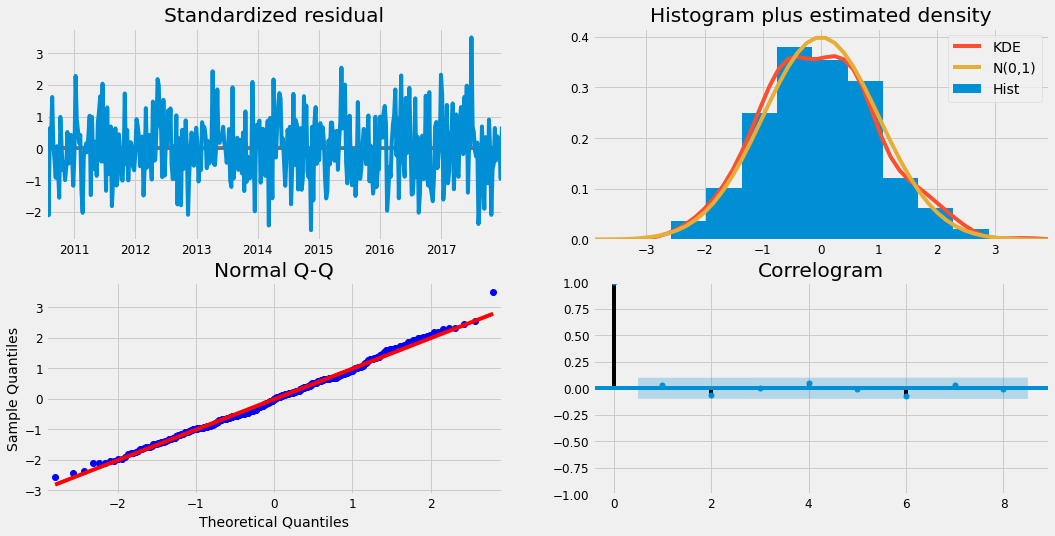

In [20]:
# Diagnóstico do modelo
modelo_sarima_v2_fit.plot_diagnostics(lags = 8, figsize = (16,8))
plt.show()

**Diagnóstico do Modelo:**

- Nossa principal preocupação é garantir que os resíduos do nosso modelo não sejam correlacionados e sejam normalmente distribuídos com média zero.

- Se o modelo SARIMA não atender a essas propriedades, é uma boa indicação de que pode ser melhorado ainda mais.

O diagnóstico do modelo sugere que o resíduo do modelo é normalmente distribuído com base no seguinte:

- No gráfico superior direito, a linha azul do KDE segue de perto a linha N (0,1). Onde N (0,1) é a notação padrão para uma distribuição normal com média 0 e desvio padrão de 1. Essa é uma boa indicação de que os resíduos são normalmente distribuídos.

- O gráfico qq no canto inferior esquerdo mostra que a distribuição ordenada de resíduos (pontos azuis) segue a tendência linear das amostras coletadas de uma distribuição normal padrão. Novamente, essa é uma forte indicação de que os resíduos são normalmente distribuídos.

- Os resíduos ao longo do tempo (gráfico superior esquerdo) não exibem nenhuma sazonalidade óbvia e parecem ser ruído branco.

- Isso é confirmado pelo gráfico de autocorrelação (isto é, correlograma) no canto inferior direito, que mostra que os resíduos da série temporal têm baixa correlação com versões atrasadas de si.

In [21]:
# Vamos fazer previsões um passo a frente
sarima_predict_2 = modelo_sarima_v2_fit.get_prediction(start = pd.to_datetime('2018-01-01'), 
                                                       end = pd.to_datetime('2020-09-01'),
                                                       dynamic = False)

In [22]:
# Intervalo de confiança
sarima_predict_conf_2 = sarima_predict_2.conf_int()
#sarima_predict_conf_2

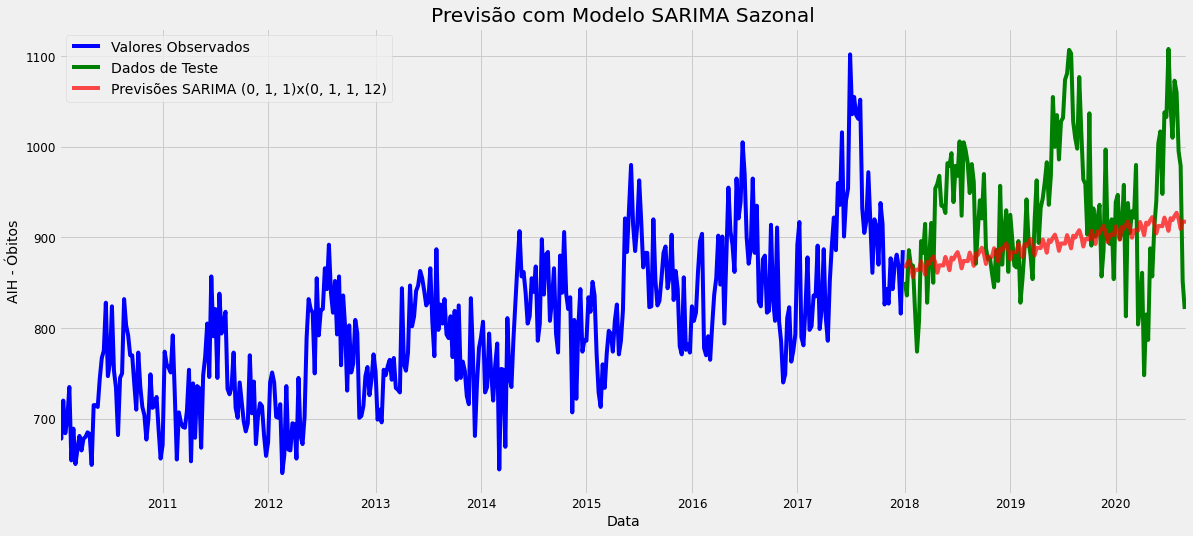

In [25]:
# Plot dos valores observados

rcParams['figure.figsize'] = 18, 8

ax = treino.plot(label = 'Valores Observados', color = 'blue')

t = teste.plot(label = 'Dados de Teste', color = 'green')

# Plot dos valores previstos
sarima_predict_2.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA (0, 1, 1)x(0, 1, 1, 12)', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
#ax.fill_between(sarima_predict_conf_2.index,
#                # lower sales
#                sarima_predict_conf_2.iloc[:, 0],
#                # upper sales
#                sarima_predict_conf_2.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão com Modelo SARIMA Sazonal')
plt.xlabel('Data')
plt.ylabel('AIH - Óbitos')
plt.legend()
plt.show()

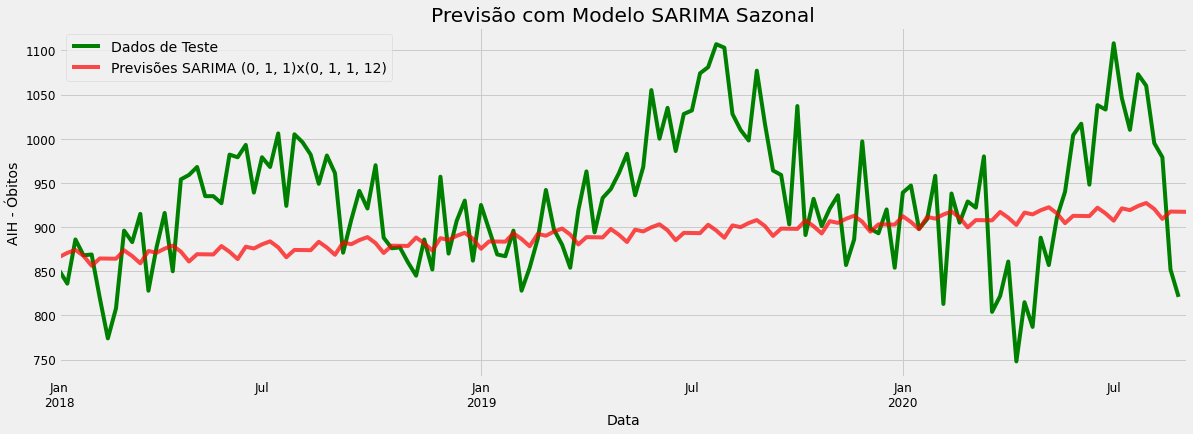

In [29]:
# Plot dos valores observados

rcParams['figure.figsize'] = 18, 6

#ax = treino.plot(label = 'Valores Observados', color = 'blue')

t = teste.plot(label = 'Dados de Teste', color = 'green')

# Plot dos valores previstos
sarima_predict_2.predicted_mean.plot(ax = t, 
                                     label = 'Previsões SARIMA (0, 1, 1)x(0, 1, 1, 12)', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Títulos e Legendas
plt.title('Previsão com Modelo SARIMA Sazonal')
plt.xlabel('Data')
plt.ylabel('AIH - Óbitos')
plt.legend(loc = 'upper left')
plt.show()

Embora ainda não esteja ideal, o modelo fez um bom trabalho nas previsões.

In [27]:
# Calculando a performance
sarima_results = performance(treino, sarima_predict_2.predicted_mean)
#sarima_results

MSE das previsões é nan
RMSE das previsões é nan
MAPE das previsões é nan


In [28]:
# Calculando a performance
sarima_results = performance(teste, sarima_predict_2.predicted_mean)
#sarima_results

MSE das previsões é 6699.1295
RMSE das previsões é 81.8482
MAPE das previsões é 6.7515


O erro do modelo aumentou um pouco, mas não podemos usar apenas uma medida para avaliar o modelo. Falaremos mais sobre isso nas aulas seguintes. Vejamos como o modelo se sai em um horizonte de previsão maior.

In [ ]:
# Forecast (previsão) de 60 passos no tempo
horizonte_60_predict_2 = modelo_sarima_v2_fit.get_forecast(steps = 48)

In [ ]:
# Intervalo de confiança
horizonte_60_predict_2_conf_2 = horizonte_60_predict_2.conf_int()
#horizonte_60_predict_2_conf_2

In [ ]:
# Plot dos valores observados

rcParams['figure.figsize'] = 18, 8

ax = treino.plot(label = 'Valores Observados', color = 'blue')

t = teste.plot(label = 'Dados de Teste', color = 'green')

# Plot dos valores previstos
horizonte_60_predict_2.predicted_mean.plot(ax = ax, label = 'SARIMAX Forecast', color = 'red')

# Plot do intervalo de confiança
#ax.fill_between(horizonte_60_predict_2_conf_2.index,
#                horizonte_60_predict_2_conf_2.iloc[:, 0],
#                horizonte_60_predict_2_conf_2.iloc[:, 1], color = 'k', alpha = .25)

# Plot
plt.title('Previsão com Modelo SARIMA Sazonal')
ax.set_xlabel('Data')
ax.set_ylabel('AIH - Óbitos')
plt.legend(loc = 'upper left')
plt.show()

Por que a área cinza aumenta? Porque quanto maior o horizonte de previsão, maior a incerteza das previsões. Veja que estamos fazendo previsões de vendas para 5 anos (60 passos no tempo em nossa série), o que aumenta a incerteza a cada novo passo de tempo previsto.

In [ ]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_sarima_v2_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95%. 

O modelo SARIMA (0, 1, 1)x(0, 1, 1, 12) fornece um bom ajuste e boa capacidade de previsão.

Como estamos até agora:
    
- Modelo 15 --> Modelo ARMA (4,5) - AIC = 38735.11 e RMSE = 236.8709
- Modelo 16 --> Modelo ARIMA Forcast (5,1,2) - AIC = 39559.670 e RMSE = 459.1013
- Modelo 17 --> Modelo SARIMA (2, 1, 2)x(2, 1, 0, 12) - AIC = 4104.139 e RMSE = 197.0291
- Modelo 18 --> Modelo SARIMA (0, 1, 1)x(0, 1, 1, 12) - AIC = 4131.634 e RMSE = 81.8482

Que diferença faz uma otimização de hiperparâmetros, não é verdade? Incrível como conseguimos melhorar a performance do nosso modelo aplicando técnicas de otimização.

Embora não seja o caso aqui, se tivermos discrepâncias entre o AIC e o RMSE, nossa escolha deve ser pelo AIC.

O RMSE é o erro do modelo com os dados atuais, de teste.

O AIC avalia a performance global do modelo e a sua capacidade de prever em um horizonte de previsão além das amostra de teste (ou seja, com novos dados). E isso é o que queremos! Logo, havendo discrepância das métricas, devemos escolher o modelo com menor AIC.

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim